# <center> Project: Image Classification and Regression
    
### Author: Rémi LELUC (MVA)
### December 2018

### Table of contents

#### [1. Useful functions](#1)
[1.1 Generate drawings](#11)<br/>
[1.2 Test basic functions](#12)<br/>
[1.3 Generate datasets](#13)<br/>
#### [2. Simple Classification](#2)<br/>
[2.1 Generate training/test sets](#21)<br/>
[2.2 Build classifier with SGD optimizer](#22)<br/>
[2.3 Build classifier with Adam optimizer](#23)<br/>
[2.4 Test models](#24)<br/>

#### [3. Vizualization of the solution](#3)<br/>
[3.1 Model with SGD optimizer](#31)<br/>
[3.2 Model with Adam optimizer](#32)<br/>
#### [4. A more difficult classification problem](#4)<br/>
[4.1 Generate new training/test datasets](#41)<br/>
[4.2 Retrain classifiers](#42)<br/>
[4.3 Convolutionnal deep network](#43)<br/>
#### [5. A regression problem](#5)<br/>
[5.1 Generate training/test datasets](#51)<br/>
[5.2 Normalize vertices](#52)<br/>
[5.3 Build model](#53)<br/>
[5.4 Vizualise predictions](#54)<br/>
#### [6. Image denoising](#6)<br/>
[6.1 Noisy images generation functions](#61)<br/>
[6.2 Build denoiser model](#62)<br/>
[6.3 Vizualization of the results](#63)<br/>

### Import Libraries

In [1]:
import sys
print(sys.version)
import warnings
warnings.filterwarnings("ignore")

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


In [2]:
# Basic libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# librairies for Deep Learning
from keras.models import Sequential,Model,Input
from keras.layers import Dense,Dropout,Activation,Flatten 
from keras.layers import GlobalAveragePooling2D,Conv2D,MaxPooling2D,UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## 1. Useful functions <a id="1"></a>

### 1.1 Generate drawings <a id="11"></a>

In [0]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

### 1.2 Test basic functions <a id="12"></a>

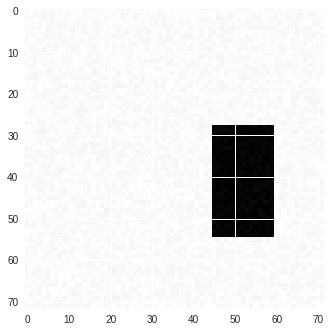

In [4]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

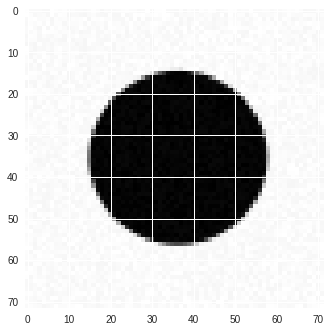

In [5]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

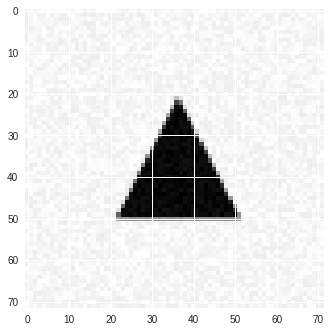

In [6]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

### 1.3 Generate datasets <a id="13"></a>

In [0]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

early_stopping_monitor = EarlyStopping(patience = 3)

## 2. Simple Classification <a id="2"></a>

### 2.1 Generate training/test sets <a id="21"></a>

In [8]:
# Generate training set
print('Generating training set')
[X_train, Y_train] = generate_dataset_classification(300, 20)
# Generate test set
print('Generating test set')
[X_test, Y_test] = generate_test_set_classification() 

Generating training set
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Generating test set
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [0]:
# Convert Y_train to categories:  
Y_train = np_utils.to_categorical(Y_train, 3) 

### 2.2 Build classifier with SGD optimizer <a id="22"></a>

In [10]:
# Creating a model with the Stochastic Gradient Descent optimizer 
model_sgd = Sequential() 
model_sgd.add(Dense(32, activation = 'relu', input_shape = (X_train.shape[1],))) 
model_sgd.add(Dense(3, activation = 'softmax')) 
model_sgd.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
model_sgd.fit(X_train, Y_train, epochs = 200, validation_split = 0.2, callbacks = [early_stopping_monitor]) 

Train on 240 samples, validate on 60 samples
Epoch 1/200
240/240 [==============================] - 2s 8ms/step - loss: 1.2399 - acc: 0.4875 - val_loss: 1.0095 - val_acc: 0.5000
Epoch 2/200
240/240 [==============================] - 0s 189us/step - loss: 1.0957 - acc: 0.4250 - val_loss: 1.0207 - val_acc: 0.5333
Epoch 3/200
240/240 [==============================] - 0s 193us/step - loss: 1.0327 - acc: 0.4917 - val_loss: 1.0341 - val_acc: 0.5833
Epoch 4/200
240/240 [==============================] - 0s 206us/step - loss: 1.0119 - acc: 0.5375 - val_loss: 0.9953 - val_acc: 0.6000
Epoch 5/200
240/240 [==============================] - 0s 197us/step - loss: 0.9791 - acc: 0.5708 - val_loss: 0.9998 - val_acc: 0.5833
Epoch 6/200
240/240 [==============================] - 0s 202us/step - loss: 0.9403 - acc: 0.5917 - val_loss: 0.8315 - val_acc: 0.6167
Epoch 7/200
240/240 [==============================] - 0s 208us/step - loss: 0.8985 - acc: 0.5792 - val_loss: 0.8299 - val_acc: 0.7333
Epoch 8/200


In [11]:
model_sgd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                165920    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 166,019
Trainable params: 166,019
Non-trainable params: 0
_________________________________________________________________


### 2.3 Build classifier with ADAM optimizer <a id="23"></a>

In [12]:
# Creating a model with the adam optimizer
model_adam = Sequential()
model_adam.add(Dense(32,activation = 'relu', input_shape = (X_train.shape[1],)))
model_adam.add(Dense(3, activation = 'softmax')) 
model_adam.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])  
model_adam.fit(X_train, Y_train, batch_size = 32, epochs = 200, validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 240 samples, validate on 60 samples
Epoch 1/200
240/240 [==============================] - 0s 1ms/step - loss: 1.8918 - acc: 0.3333 - val_loss: 1.2336 - val_acc: 0.4833
Epoch 2/200
240/240 [==============================] - 0s 238us/step - loss: 1.1373 - acc: 0.4583 - val_loss: 0.8436 - val_acc: 0.8667
Epoch 3/200
240/240 [==============================] - 0s 234us/step - loss: 0.9788 - acc: 0.5792 - val_loss: 0.7797 - val_acc: 0.8833
Epoch 4/200
240/240 [==============================] - 0s 232us/step - loss: 0.8375 - acc: 0.7375 - val_loss: 0.7411 - val_acc: 0.7833
Epoch 5/200
240/240 [==============================] - 0s 227us/step - loss: 0.7802 - acc: 0.7250 - val_loss: 0.7011 - val_acc: 0.8000
Epoch 6/200
240/240 [==============================] - 0s 225us/step - loss: 0.7488 - acc: 0.6875 - val_loss: 0.6185 - val_acc: 0.8500
Epoch 7/200
240/240 [==============================] - 0s 231us/step - loss: 0.6527 - acc: 0.8500 - val_loss: 0.5771 - val_acc: 0.9333
Epoch 8/200


In [13]:
model_adam.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                165920    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 166,019
Trainable params: 166,019
Non-trainable params: 0
_________________________________________________________________


### 2.4 Test models <a id="24"></a>

We check the results of the classifiers :

In [14]:
# Testing model with SGD 
X_test_sgd = generate_a_disk() 
X_test_sgd = X_test_sgd.reshape(1, X_test_sgd.shape[0]) 
model_sgd.predict(X_test_sgd)

array([[0., 1., 0.]], dtype=float32)

In [15]:
# Testing model with Adam
X_test_adam = generate_a_disk() 
X_test_adam = X_test_adam.reshape(1, X_test_adam.shape[0]) 
model_adam.predict(X_test_sgd)

array([[0., 1., 0.]], dtype=float32)

## 3. Vizualization of the solution <a id="3"></a>

### 3.1 Model with SGD optimizer <a id="31"></a>

We check the weights of our model with SGD optimizer

- First array (dimension 5184 x 32): we get the weight of each of the 5184 pixels for each of the 32 nodes (of the hidden layer)
- Second array (dimension 32): biases of the input to hidden weights
- Third array (dimension 32 x 3): we get the weights of each node for each of the 3 categories (rectangle, disk, triangle)
- Fourth array (dimension 3): biases of the hidden layer to output weights

In [16]:
weights_sgd = model_sgd.get_weights()
weights_sgd

[array([[-0.01296304, -0.02071047,  0.03327185, ..., -0.01815189,
         -0.0316669 , -0.00466187],
        [ 0.01562306,  0.02784667, -0.01185082, ...,  0.01895938,
          0.02068105,  0.02358796],
        [ 0.02111619, -0.02750048,  0.0224918 , ...,  0.01435921,
         -0.0175932 , -0.02348386],
        ...,
        [-0.03200686, -0.01521206, -0.01002791, ..., -0.00114096,
         -0.00204379, -0.033257  ],
        [-0.0084409 ,  0.02535716, -0.00370674, ..., -0.01837408,
          0.02022093, -0.02691463],
        [ 0.03119038, -0.03067642, -0.00287452, ...,  0.02082916,
         -0.01395327,  0.00878945]], dtype=float32),
 array([-1.59957970e-04, -5.53831109e-04, -3.59852187e-04, -1.05093187e-03,
        -1.38546195e-04,  2.13003819e-04,  0.00000000e+00, -8.72561868e-05,
        -4.86051402e-04,  2.93843378e-03, -1.45512470e-03, -5.30527555e-04,
        -4.91065206e-04, -7.77880850e-05, -1.48213492e-03, -1.01904140e-03,
         0.00000000e+00, -4.15018119e-04,  0.00000000e

In [17]:
# matrix model SGD
matrix_model_sgd = np.dot(weights_sgd[0],weights_sgd[2])
print(matrix_model_sgd.shape)

(5184, 3)


### Visualize columns

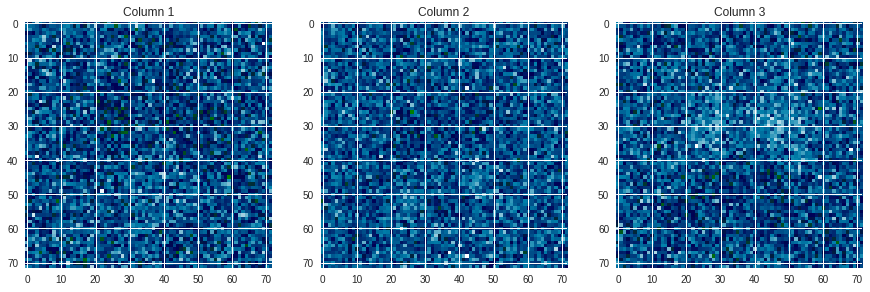

In [18]:
# Visualize columns
fig = plt.figure(figsize=(15,20))
for k in range(3):
    ax = plt.subplot(1,3,k+1)
    ax.set_title('Column %d' %(k+1))
    plt.imshow(matrix_model_sgd[:,k].reshape(72,72), cmap='ocean')

### 3.2 Model with Adam optimizer <a id="32"></a>

We check the weights of our model with Adam optimizer

-  First array (dimension 5184 x 32): we get the weight of each of the 5184 pixels for each of the 32 nodes (of the hidden layer)
- Second array (dimension 32): biases of the input to hidden weights
- Third array (dimension 32 x 3): we get the weights of each node for each of the 3 categories (rectangle, disk, triangle)
- Fourth array (dimension 3): biases of the hidden layer to output weights

In [19]:
weights_adam = model_adam.get_weights()
weights_adam

[array([[ 0.01602738, -0.02974765, -0.0027265 , ..., -0.01276281,
         -0.00209385, -0.03524219],
        [-0.0193007 ,  0.00428684,  0.01454775, ..., -0.0151699 ,
         -0.00211049,  0.00179487],
        [-0.01317403,  0.00691301,  0.02121054, ...,  0.01646998,
          0.01452686, -0.00142236],
        ...,
        [-0.00484058, -0.01000204, -0.02847917, ..., -0.00684451,
         -0.00949857, -0.03027035],
        [-0.03500758, -0.00718551,  0.02400651, ...,  0.01373336,
          0.00753133,  0.02896371],
        [-0.00193519,  0.00910892,  0.00012447, ..., -0.0358776 ,
         -0.03131319, -0.02165352]], dtype=float32),
 array([-0.006135  , -0.00555792,  0.        , -0.00556078, -0.00555753,
        -0.00555541, -0.00423652,  0.        ,  0.        ,  0.0001607 ,
        -0.00555206,  0.00446884,  0.00360749,  0.        , -0.00550756,
         0.        , -0.00555776, -0.00555853, -0.00555824, -0.00555758,
        -0.00555868, -0.00391919, -0.00555844,  0.        ,  0.002

In [20]:
# matrix model Adam
matrix_model_adam = np.dot(weights_adam[0],weights_adam[2])
print(matrix_model_adam.shape)

(5184, 3)


### Visualize columns

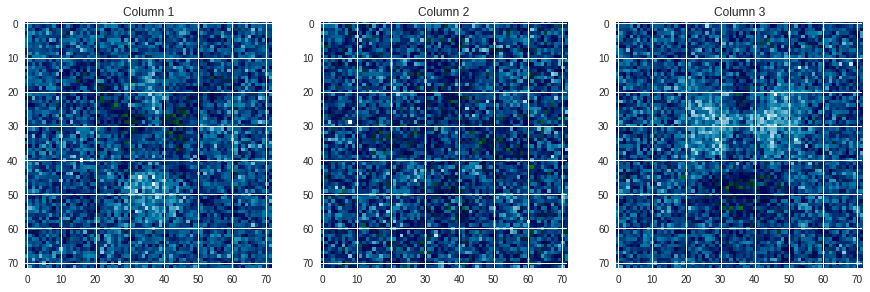

In [21]:
# Visualize columns
fig = plt.figure(figsize=(15,20))
for k in range(3):
    ax = plt.subplot(1,3,k+1)
    ax.set_title('Column %d' %(k+1))
    plt.imshow(matrix_model_adam[:,k].reshape(72,72), cmap='ocean')

### Results
- We can see some formes in the weights of the model with Adal optimizer that cannot be seen in the model with SGD optimizer.

## 4. A more difficult classification problem <a id="4"></a>

### 4.1 Generate new training/test datasets <a id="41"></a>

In [22]:
# We have a new dataset (with free_location = True) 
print('Generating new training set')
[X_train_new, Y_train_new] = generate_dataset_classification(300, 20, True)
print('Generating new test set')
[X_test_new, Y_test_new] = generate_test_set_classification()

Generating new training set
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Generating new test set
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [0]:
Y_train_new = np_utils.to_categorical(Y_train_new, 3)

In [24]:
# Shapes
print('X_train_new shape :', X_train_new.shape)
print('Y_train_new shape :', Y_train_new.shape)
print('X_test_new shape :', X_test_new.shape)
print('Y_test_new shape :', Y_test_new.shape)

X_train_new shape : (300, 5184)
Y_train_new shape : (300, 3)
X_test_new shape : (300, 5184)
Y_test_new shape : (300, 3)


### 4.2 Retrain classifiers <a id="42"></a>

### Model with SGD optimizer

In [25]:
model_sgd.fit(X_train_new, Y_train_new, epochs = 200, validation_split = 0.2, callbacks = [early_stopping_monitor]) 
score_sgd = model_sgd.evaluate(X_test_new,Y_test_new)

Train on 240 samples, validate on 60 samples
Epoch 1/200
240/240 [==============================] - 0s 248us/step - loss: 1.8820 - acc: 0.3208 - val_loss: 1.1063 - val_acc: 0.3500
Epoch 2/200
240/240 [==============================] - 0s 195us/step - loss: 1.0822 - acc: 0.3792 - val_loss: 1.0994 - val_acc: 0.3667
Epoch 3/200
240/240 [==============================] - 0s 210us/step - loss: 1.0752 - acc: 0.3875 - val_loss: 1.0939 - val_acc: 0.3500
Epoch 4/200
240/240 [==============================] - 0s 183us/step - loss: 1.0756 - acc: 0.4000 - val_loss: 1.0930 - val_acc: 0.3333
Epoch 5/200
240/240 [==============================] - 0s 217us/step - loss: 1.0760 - acc: 0.4042 - val_loss: 1.0938 - val_acc: 0.3333
Epoch 6/200
240/240 [==============================] - 0s 206us/step - loss: 1.0748 - acc: 0.3917 - val_loss: 1.0951 - val_acc: 0.3333
Epoch 7/200
300/300 [==============================] - 0s 91us/step


In [26]:
print('Score SGD optimizer')
print(score_sgd)

Score SGD optimizer
[1.0701135714848837, 0.36666666666666664]


### Model with Adam optimizer

In [27]:
model_adam.fit(X_train_new, Y_train_new, epochs = 200, validation_split = 0.2, callbacks = [early_stopping_monitor]) 
score_adam = model_adam.evaluate(X_test_new,Y_test_new)

Train on 240 samples, validate on 60 samples
Epoch 1/200
240/240 [==============================] - 0s 275us/step - loss: 1.8124 - acc: 0.3750 - val_loss: 1.5200 - val_acc: 0.2833
Epoch 2/200
240/240 [==============================] - 0s 225us/step - loss: 1.3770 - acc: 0.3667 - val_loss: 1.3284 - val_acc: 0.3000
Epoch 3/200
240/240 [==============================] - 0s 243us/step - loss: 1.1708 - acc: 0.4250 - val_loss: 1.9741 - val_acc: 0.3500
Epoch 4/200
240/240 [==============================] - 0s 238us/step - loss: 1.5803 - acc: 0.3875 - val_loss: 1.2818 - val_acc: 0.4000
Epoch 5/200
240/240 [==============================] - 0s 289us/step - loss: 1.3002 - acc: 0.4333 - val_loss: 1.2962 - val_acc: 0.3667
Epoch 6/200
240/240 [==============================] - 0s 257us/step - loss: 1.2890 - acc: 0.4333 - val_loss: 1.2443 - val_acc: 0.3833
Epoch 7/200
240/240 [==============================] - 0s 239us/step - loss: 1.2134 - acc: 0.4417 - val_loss: 1.2657 - val_acc: 0.3833
Epoch 8/20

In [28]:
print('Score Adam optimizer')
print(score_adam)

Score Adam optimizer
[0.9412565143903097, 0.5766666666666667]


### Results
- Accuracy with SGD optimizer : 37%
- Accuracy with Adam optimizer : 58%

We need to build another classifier based on deep neural networks.

### 4.3 Convolutionnal deep network <a id="43"></a>

In [29]:
# Reformate the input
X_train_new = X_train_new.reshape(X_train_new.shape[0], 72, 72, -1)
X_train_new = X_train_new.astype('float32') 
print(X_train_new.shape)
X_test_new = X_test_new.reshape(X_test_new.shape[0], 72, 72, -1)
X_test_new = X_test_new.astype('float32')

(300, 72, 72, 1)


In [30]:
model_deep = Sequential()
model_deep.add(Conv2D(16,(5,5),activation='relu',input_shape=(72,72,1)))
print(model_deep.output_shape)

(None, 68, 68, 16)


In [31]:
# We add a (2,2) MaxPooling2D filter
model_deep.add(MaxPooling2D(pool_size=(2,2)))
print(model_deep.output_shape)

(None, 34, 34, 16)


In [32]:
model_deep.add(Dropout(0.25))
model_deep.add(Flatten())
print(model_deep.output_shape)

(None, 18496)


In [33]:
model_deep.add(Dense(128,activation='relu'))
print(model_deep.output_shape)

(None, 128)


In [34]:
model_deep.add(Dropout(0.25))
model_deep.add(Dense(3,activation='softmax'))
print(model_deep.output_shape)

(None, 3)


In [35]:
# Compile deep model
model_deep.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Fit the model
model_deep.fit(X_train_new,Y_train_new,epochs=200,validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 240 samples, validate on 60 samples
Epoch 1/200
240/240 [==============================] - 3s 10ms/step - loss: 2.2491 - acc: 0.3875 - val_loss: 1.4254 - val_acc: 0.3333
Epoch 2/200
240/240 [==============================] - 0s 498us/step - loss: 1.2684 - acc: 0.4083 - val_loss: 1.0862 - val_acc: 0.3167
Epoch 3/200
240/240 [==============================] - 0s 500us/step - loss: 1.0351 - acc: 0.4375 - val_loss: 1.0376 - val_acc: 0.3833
Epoch 4/200
240/240 [==============================] - 0s 468us/step - loss: 0.9687 - acc: 0.5500 - val_loss: 0.9841 - val_acc: 0.5500
Epoch 5/200
240/240 [==============================] - 0s 490us/step - loss: 0.9104 - acc: 0.6250 - val_loss: 1.0173 - val_acc: 0.4333
Epoch 6/200
240/240 [==============================] - 0s 483us/step - loss: 0.8611 - acc: 0.6375 - val_loss: 0.9442 - val_acc: 0.5000
Epoch 7/200
240/240 [==============================] - 0s 527us/step - loss: 0.8154 - acc: 0.7083 - val_loss: 0.9188 - val_acc: 0.5000
Epoch 8/200

In [36]:
# Evaluate the model
score_deep = model_deep.evaluate(X_test_new,Y_test_new)

300/300 [==============================] - 0s 169us/step


In [37]:
print('Score Deep network')
print(score_deep)

Score Deep network
[0.805800240834554, 0.66]


In [38]:
# Loss of the model
print(model_deep.metrics_names[0],score_deep[0])

loss 0.805800240834554


In [39]:
# Accuracy of the model on test set
print('%s: %.2f%%'%(model_deep.metrics_names[1],score_deep[1]*100))

acc: 66.00%


### Results
- Accuracy is much better : 66%

## 5. A regression problem <a id="5"></a>

### 5.1 Generate training/test sets <a id="51"></a>

In [40]:
# Generate new dataset
print('Generating training set')
[X_train_reg, Y_train_reg] = generate_dataset_regression(2000, 20)
print('Generating test set')
[X_test_reg, Y_test_reg] = generate_test_set_regression()

Generating training set
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
Generating test set
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110


In [41]:
# Check shapes
print('X_train_reg shape: ', X_train_reg.shape)
print('Y_train_reg shape: ', Y_train_reg.shape)
print('X_test_reg shape: ', X_test_reg.shape)
print('Y_test_reg shape: ', Y_test_reg.shape)

X_train_reg shape:  (2000, 5184)
Y_train_reg shape:  (2000, 6)
X_test_reg shape:  (300, 5184)
Y_test_reg shape:  (300, 6)


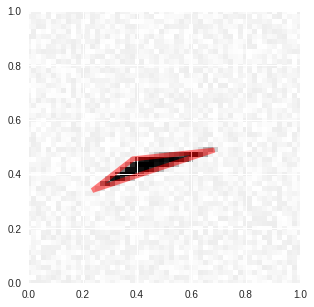

In [42]:
visualize_prediction(X_train_reg[0],Y_train_reg[0])

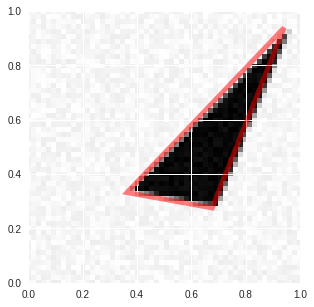

In [43]:
visualize_prediction(X_test_reg[0],Y_test_reg[0])

### 5.2 Normalize vertices <a id="52"></a>

In [0]:
def normalize_vertices(Y):
    d = [[Y[0],Y[1],np.sqrt(Y[0]**2 + Y[1]**2)],
         [Y[2],Y[3],np.sqrt(Y[2]**2 + Y[3]**2)],
         [Y[4],Y[5],np.sqrt(Y[4]**2 + Y[5]**2)]]
    d.sort(key = lambda x:x[2])
    y = np.array([d[0][0],d[0][1],d[1][0],d[1][1],d[2][0],d[2][1]])
    return y

In [0]:
# Normalize Y_train_reg 
for k in range(Y_train_reg.shape[0]):
    Y_train_reg[k] = normalize_vertices(Y_train_reg[k])

In [0]:
# Normalize Y_test_reg 
for k in range(Y_test_reg.shape[0]):
    Y_test_reg[k] = normalize_vertices(Y_test_reg[k])

In [0]:
# Regormate train and test inputs
X_train_reg = X_train_reg.reshape(X_train_reg.shape[0],72,72,1)
X_train_reg = X_train_reg.astype('float32')

X_test_reg = X_test_reg.reshape(X_test_reg.shape[0],72,72,1)
X_test_reg = X_test_reg.astype('float32')

In [48]:
print('X_train_reg shape: ', X_train_reg.shape)
print('X_test_reg shape: ', X_test_reg.shape)

X_train_reg shape:  (2000, 72, 72, 1)
X_test_reg shape:  (300, 72, 72, 1)


### 5.3 Build model <a id="53"></a>

In [0]:
# Parameters
pixel_rows = 72
pixel_cols = 72
input_shape = (pixel_rows,pixel_cols,1)
number_coordinates = 6
epochs_reg = 30
validation_split = 0.2
batch_size = 32
early_stopping_monitor_reg = EarlyStopping(patience=5)
nb_filter_reg = 32
filter_size = (5,5)
pixel_window = (2,2)

In [0]:
# Build model
model_reg = Sequential()
model_reg.add(Conv2D(32,activation='relu',input_shape=input_shape,kernel_size=(5,5),padding="same"))
model_reg.add(MaxPooling2D(pool_size=(2,2),padding="same"))
model_reg.add(Conv2D(32,(5,5),activation='relu',padding="same"))
model_reg.add(MaxPooling2D(pool_size=(2,2),padding="same"))
model_reg.add(Flatten())
model_reg.add(Dense(256,activation='relu'))
model_reg.add(Dense(256,activation='relu'))
model_reg.add(Dense(128,activation='relu'))
model_reg.add(Dense(6))

In [51]:
# Compile model
model_reg.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
model_reg.fit(X_train_reg,Y_train_reg,
              epochs=epochs_reg,
              batch_size=batch_size,
              validation_split=validation_split,
              shuffle=True,
              callbacks=[early_stopping_monitor_reg],
              verbose=1)

Train on 1600 samples, validate on 400 samples
Epoch 1/30
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0640 - acc: 0.5150 - val_loss: 0.0424 - val_acc: 0.6400
Epoch 2/30
1600/1600 [==============================] - 1s 666us/step - loss: 0.0344 - acc: 0.6281 - val_loss: 0.0316 - val_acc: 0.6725
Epoch 3/30
1600/1600 [==============================] - 1s 651us/step - loss: 0.0261 - acc: 0.6887 - val_loss: 0.0248 - val_acc: 0.7150
Epoch 4/30
1600/1600 [==============================] - 1s 653us/step - loss: 0.0197 - acc: 0.7400 - val_loss: 0.0202 - val_acc: 0.7700
Epoch 5/30
1600/1600 [==============================] - 1s 655us/step - loss: 0.0165 - acc: 0.7638 - val_loss: 0.0192 - val_acc: 0.7250
Epoch 6/30
1600/1600 [==============================] - 1s 654us/step - loss: 0.0129 - acc: 0.7894 - val_loss: 0.0153 - val_acc: 0.7700
Epoch 7/30
1600/1600 [==============================] - 1s 651us/step - loss: 0.0120 - acc: 0.7738 - val_loss: 0.0168 - val_acc: 0.7675
Epo

In [52]:
# Evaluate model
score_reg = model_reg.evaluate(X_test_reg,Y_test_reg)

300/300 [==============================] - 0s 246us/step


In [53]:
# Loss of the model
print(model_reg.metrics_names[0],score_reg[0])

loss 0.012365276974936326


In [54]:
# Accuracy of the model
print(model_reg.metrics_names[1],score_reg[1]*100)

acc 80.6666665871938


### Results
- A good accuracy of 80%

### 5.4 Vizualise predictions <a id="54"></a>

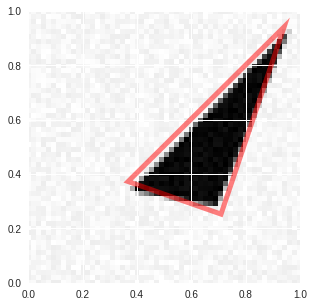

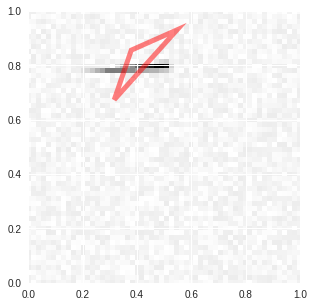

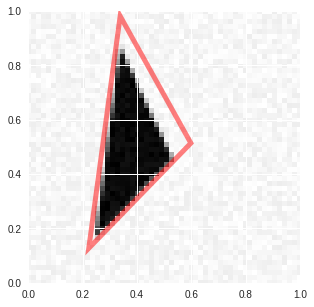

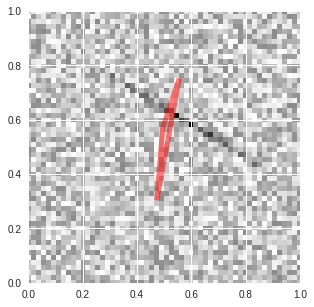

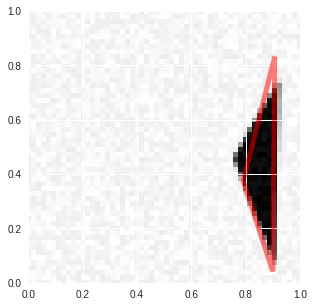

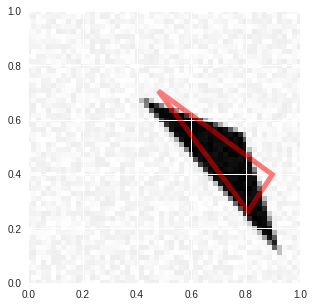

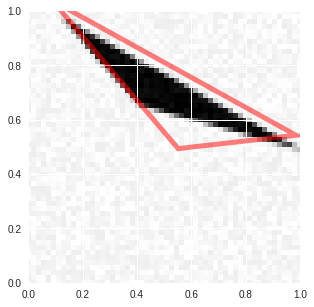

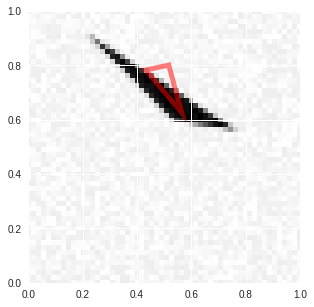

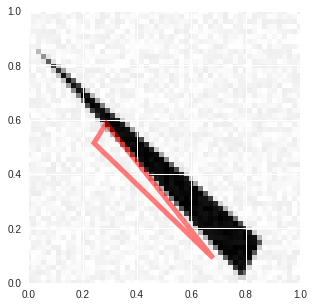

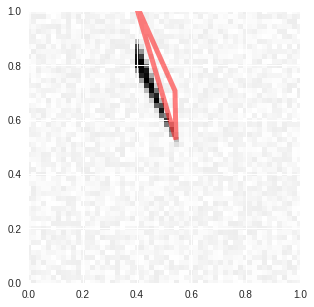

In [55]:
for k in range(10):
    visualize_prediction(X_test_reg[k],model_reg.predict(X_test_reg)[k])

## 6. Image denoising<a id="6"></a>

### 6.1 Noisy images generation functions <a id="61"></a>

In [0]:
def generate_a_drawing_noise(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_noise, imdata

In [0]:
def generate_a_rectangle_noise(free_location=False):
    noise = np.random.randint(0,50)
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_noise(figsize, U, V, noise)

def generate_a_disk_noise(free_location=False):
    noise = np.random.randint(0,50)
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_noise(figsize, U, V, noise)
  
def generate_a_triangle_noise(free_location=False):
    noise = np.random.randint(0,50)
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing_noise(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_noise(nb_samples, free_location=False):
    # Getting im_size:
    noise = np.random.randint(0,50)
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,2,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle_noise(free_location)
        elif category == 1: 
            X[i] = generate_a_disk_noise(free_location)
        else:
            [X[i], V] = generate_a_triangle_noise(free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X,Y]

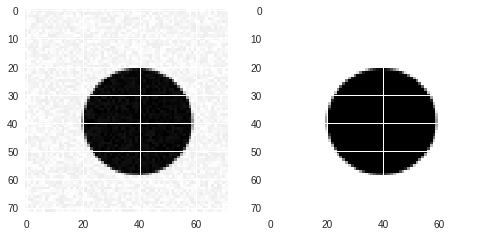

In [58]:
im = generate_a_disk_noise(True)
plt.subplot(1,2,1)
plt.imshow(im[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(im[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

### 6.2 Build denoiser model

We train our neural network on a set of triangle images

In [0]:
# Generate training set of triangles
train_size = 2000
train_set = np.array([generate_a_triangle_noise(True)[0] for k in range(train_size)])
X_train = train_set[:,0]
Y_train = train_set[:,1]
X_train = X_train.reshape(train_size,IMAGE_SIZE,IMAGE_SIZE,1)
Y_train = Y_train.reshape(train_size,IMAGE_SIZE,IMAGE_SIZE,1)
X_train /= 255
Y_train /= 255

In [0]:
input_ = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


denoiser = Model(input_, output)
denoiser.compile(optimizer="adam", loss='binary_crossentropy')

In [61]:
early_stopping_monitor_noise = EarlyStopping(patience = 3)
denoiser.fit(X_train, Y_train, epochs=100,
             batch_size=128,validation_split=0.2,
             shuffle=True, verbose=1,callbacks=[early_stopping_monitor_noise])

Train on 1600 samples, validate on 400 samples
Epoch 1/100
1600/1600 [==============================] - 2s 1ms/step - loss: 0.4862 - val_loss: 0.1663
Epoch 2/100
1600/1600 [==============================] - 1s 637us/step - loss: 0.1768 - val_loss: 0.1216
Epoch 3/100
1600/1600 [==============================] - 1s 643us/step - loss: 0.0944 - val_loss: 0.0563
Epoch 4/100
1600/1600 [==============================] - 1s 639us/step - loss: 0.0413 - val_loss: 0.0293
Epoch 5/100
1600/1600 [==============================] - 1s 637us/step - loss: 0.0281 - val_loss: 0.0254
Epoch 6/100
1600/1600 [==============================] - 1s 638us/step - loss: 0.0241 - val_loss: 0.0221
Epoch 7/100
1600/1600 [==============================] - 1s 639us/step - loss: 0.0216 - val_loss: 0.0204
Epoch 8/100
1600/1600 [==============================] - 1s 633us/step - loss: 0.0201 - val_loss: 0.0190
Epoch 9/100
1600/1600 [==============================] - 1s 634us/step - loss: 0.0186 - val_loss: 0.0179
Epoch 10/1

### 6.3 Vizualization of the results <a id="63"></a>

### On a triangle dataset

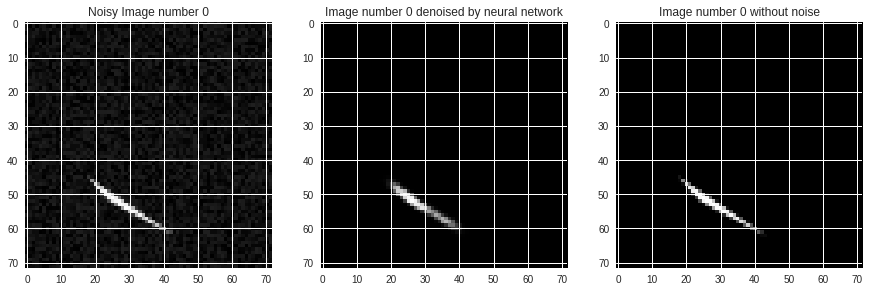

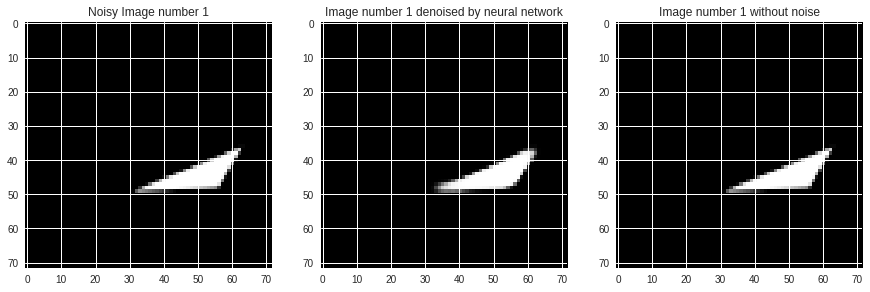

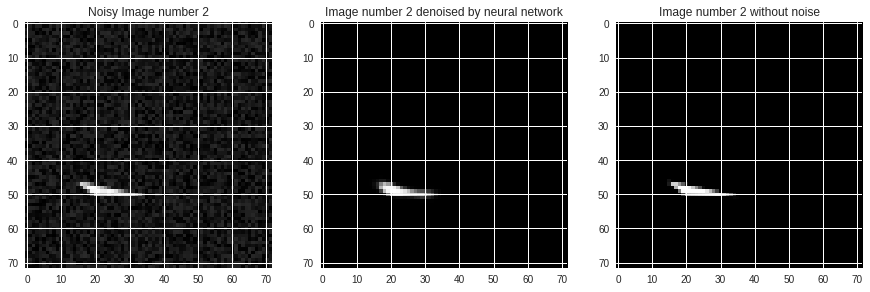

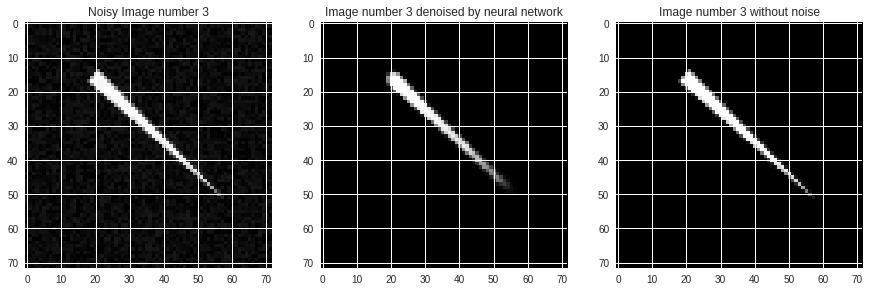

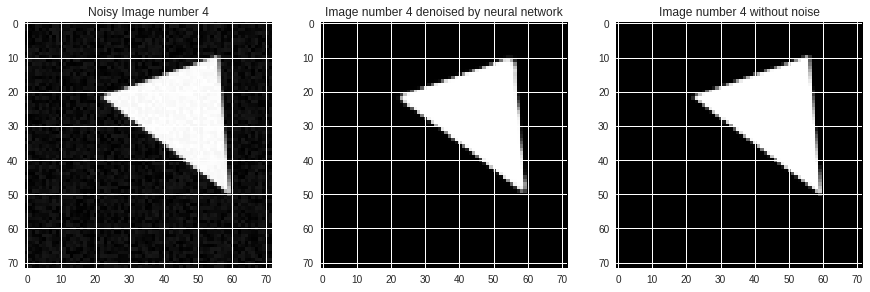

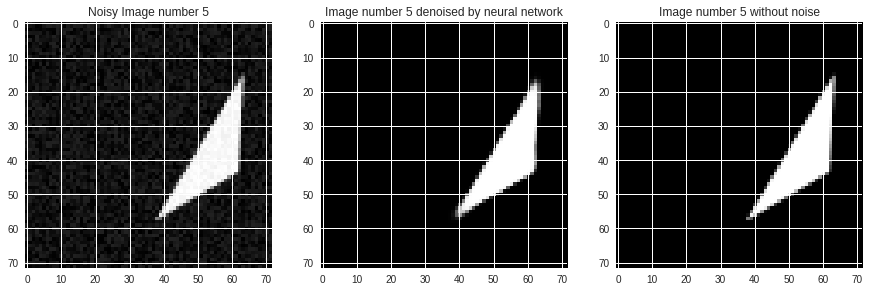

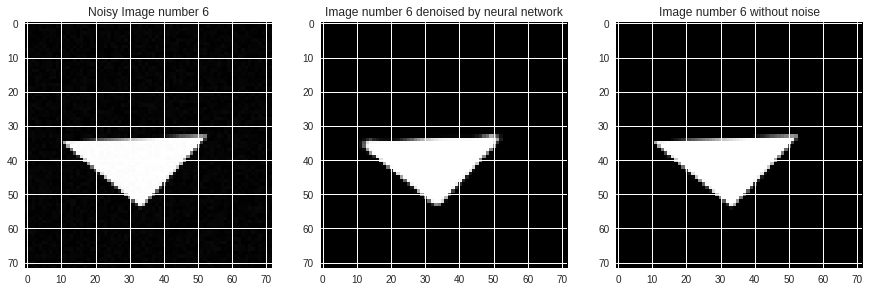

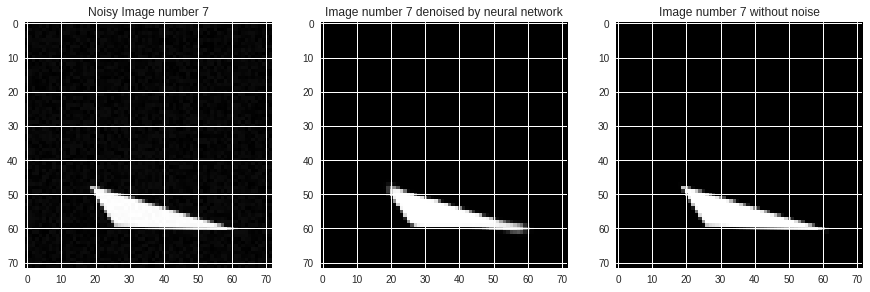

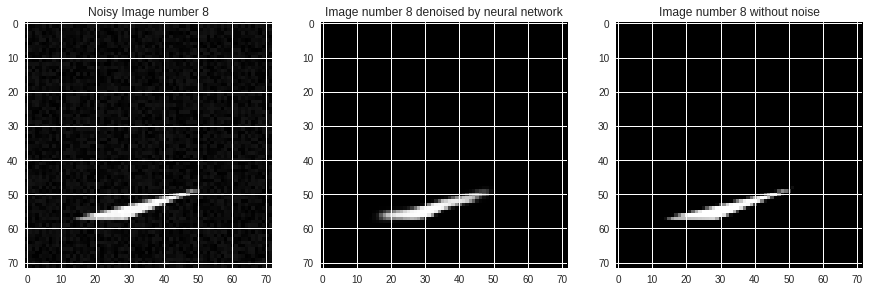

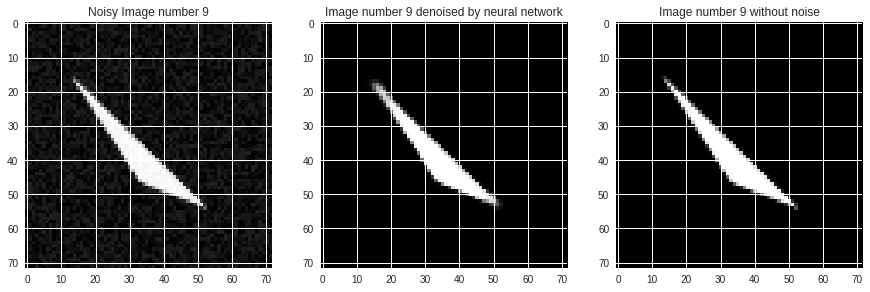

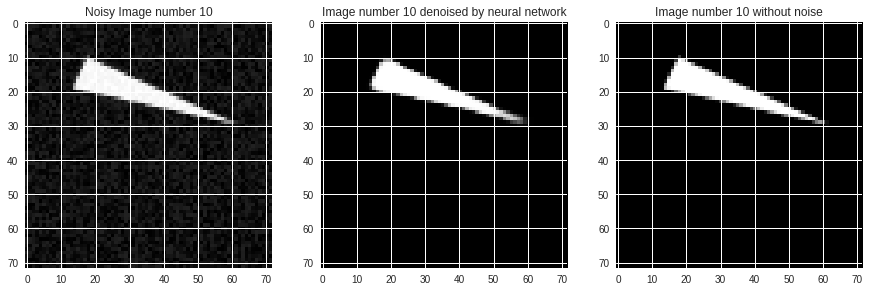

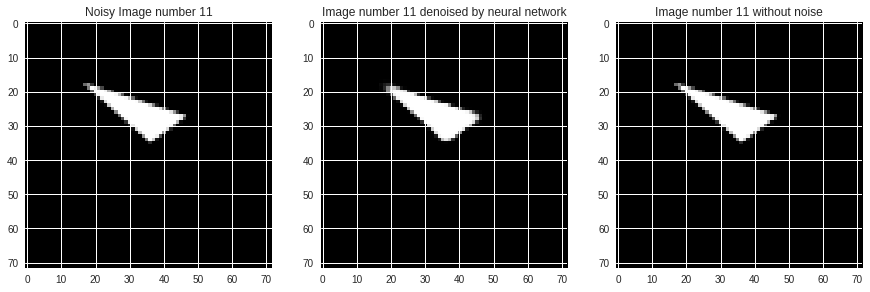

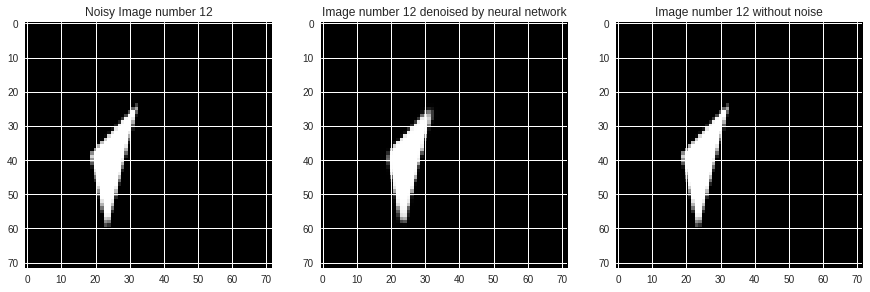

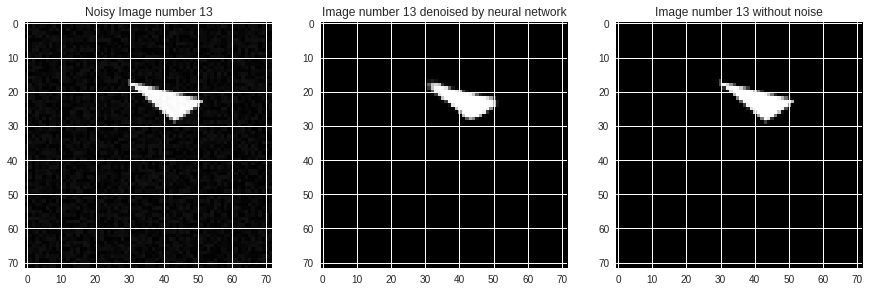

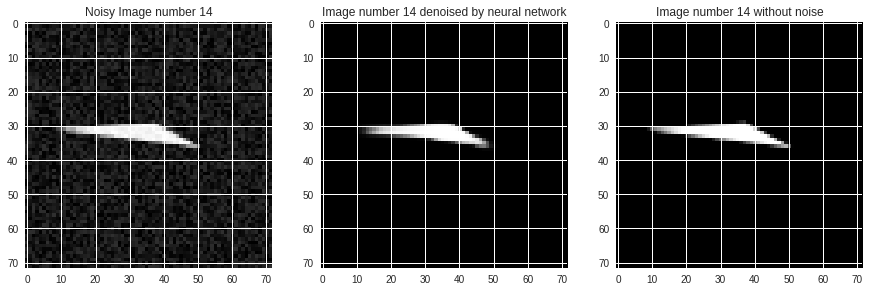

In [62]:
# Generate test set of triangles
test_size = 15
test_set = np.array([generate_a_triangle_noise(True)[0] for k in range(test_size)])
X_test = test_set[:,0]
Y_test = test_set[:,1]
X_test = X_test.reshape(test_size,IMAGE_SIZE,IMAGE_SIZE,1)
Y_test = Y_test.reshape(test_size,IMAGE_SIZE,IMAGE_SIZE,1)
X_test /= 255
Y_test /= 255

for j in range(test_size):
    fig = plt.figure(figsize = (15,30))
    fig.tight_layout()
    ax = plt.subplot(1, 3, 1)
    plt.imshow(X_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)))
    plt.title("Noisy Image number "+str(j))

    ax = plt.subplot(1, 3, 2)
    plt.imshow((denoiser.predict(X_test[j].reshape((1,IMAGE_SIZE,IMAGE_SIZE,1)))).reshape((IMAGE_SIZE,IMAGE_SIZE)))
    plt.title("Image number "+str(j) +" denoised by neural network")

    ax = plt.subplot(1, 3, 3)
    plt.imshow(Y_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)))
    plt.title("Image number "+str(j) +" without noise")

### On a rectangle dataset

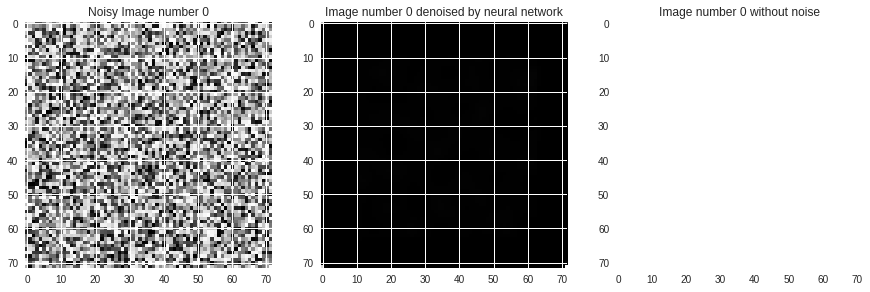

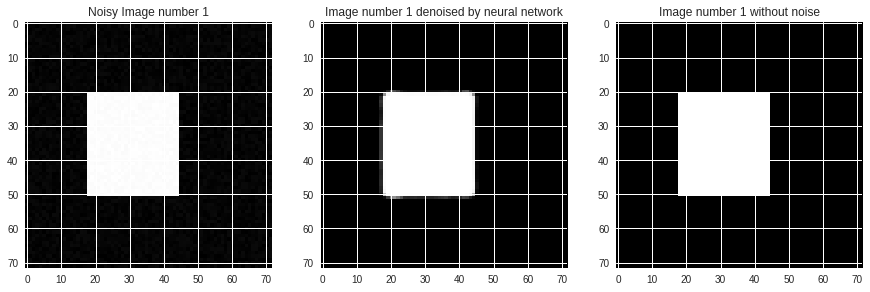

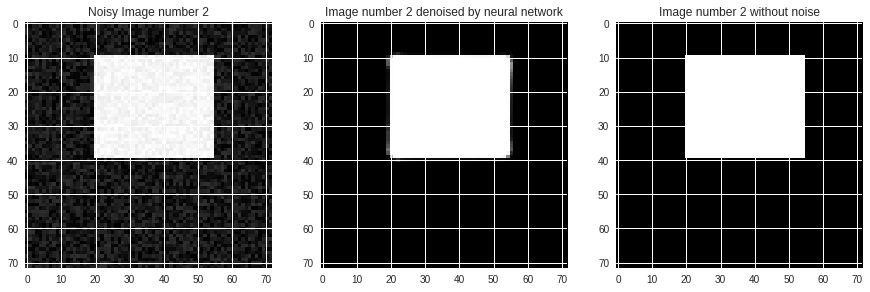

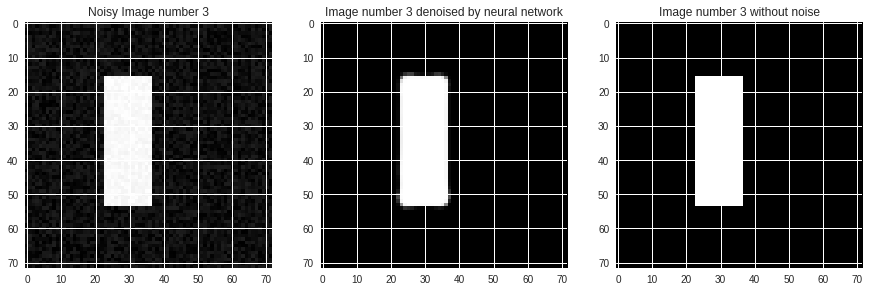

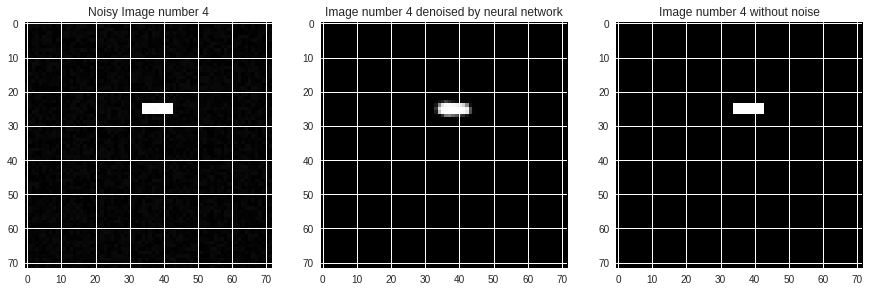

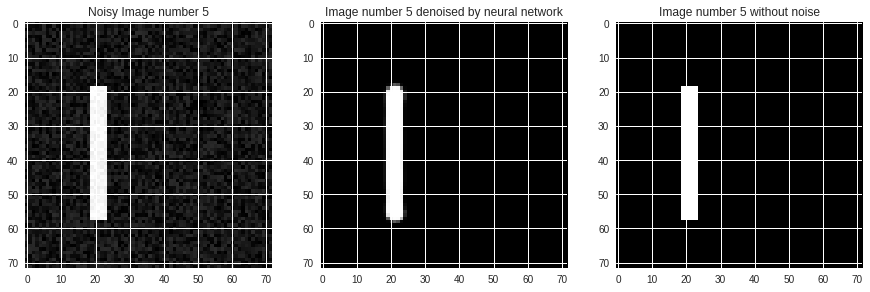

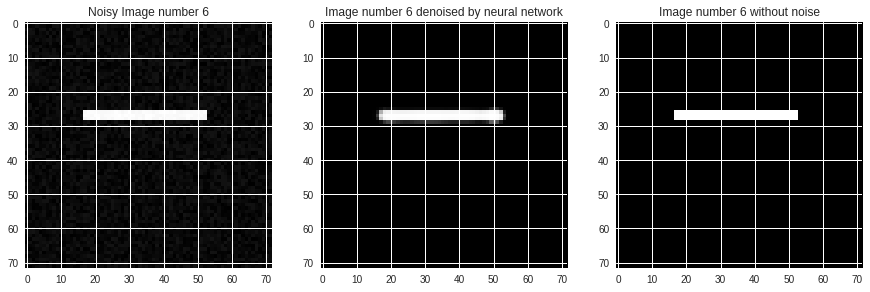

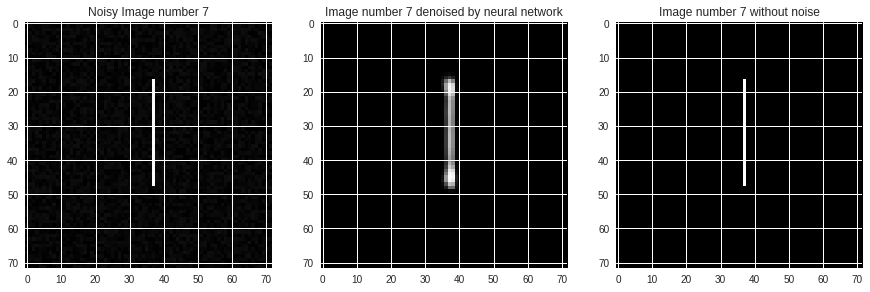

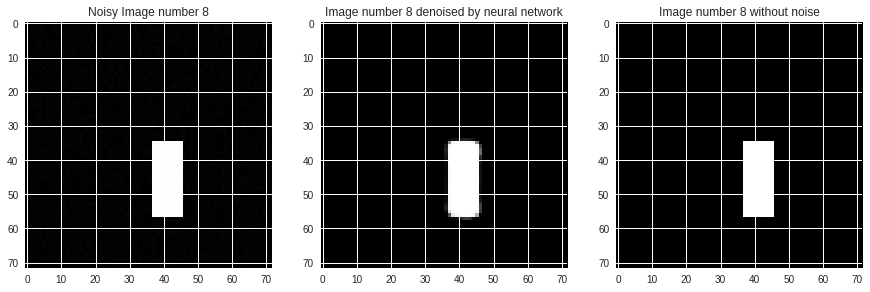

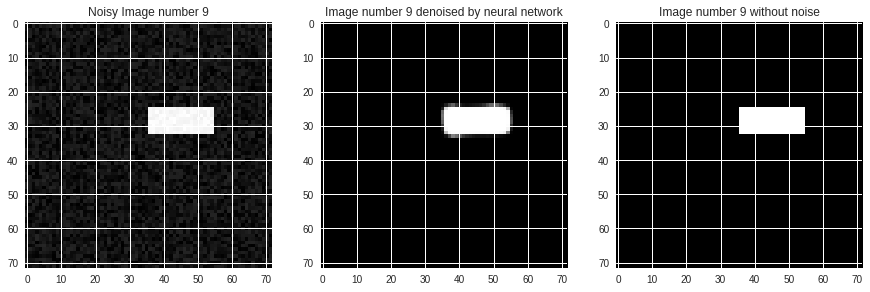

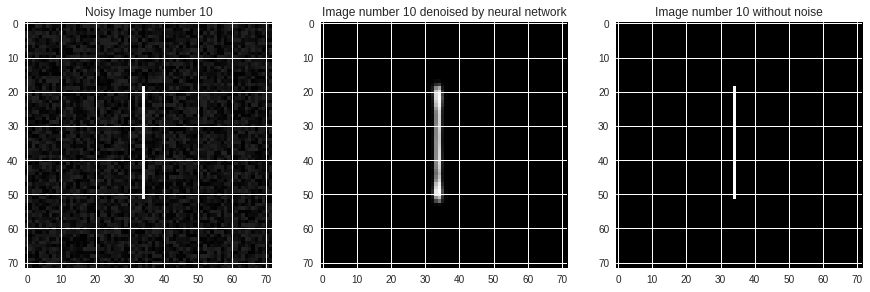

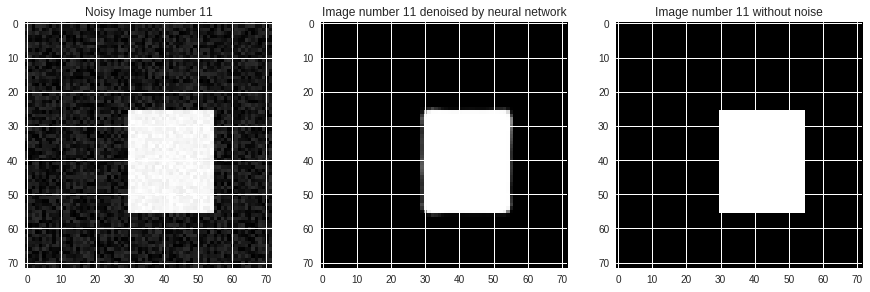

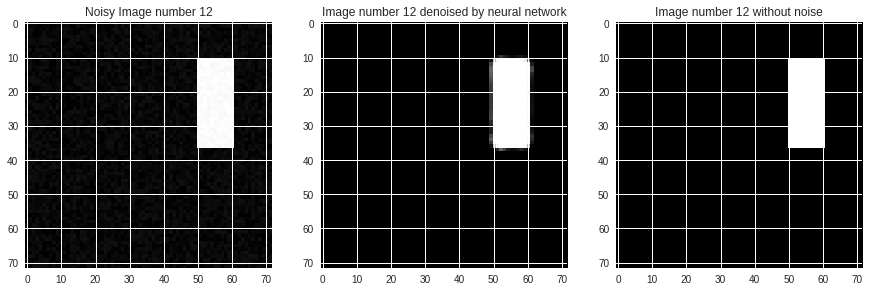

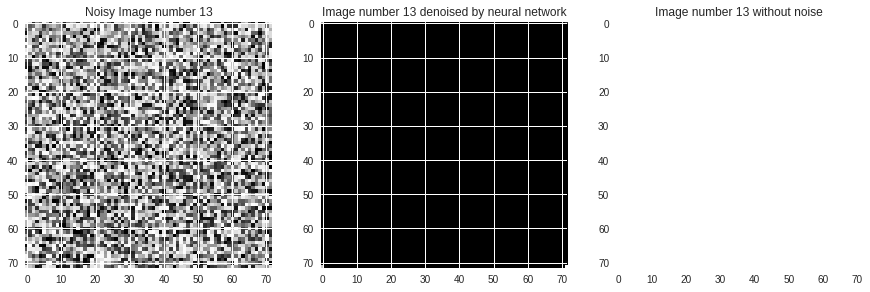

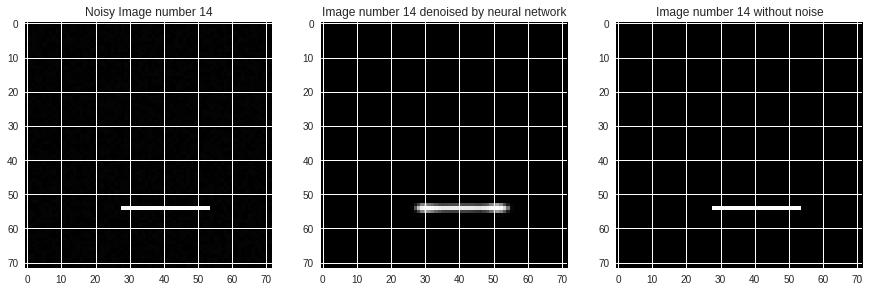

In [64]:
# Generate test set of rectangles
test_set = np.array([generate_a_rectangle_noise(True) for k in range(test_size)])
X_test = test_set[:,0]
Y_test = test_set[:,1]
X_test = X_test.reshape(test_size, IMAGE_SIZE, IMAGE_SIZE, 1)
Y_test = Y_test.reshape(test_size, IMAGE_SIZE, IMAGE_SIZE, 1)
X_test /= 255
Y_test /= 255

for j in range(test_size):
    fig = plt.figure(figsize = (15,30))
    fig.tight_layout()
    ax = plt.subplot(1, 3, 1)
    im = X_test[j]
    plt.imshow(im.reshape((IMAGE_SIZE,IMAGE_SIZE)))
    plt.title("Noisy Image number "+str(j))

    ax = plt.subplot(1, 3, 2)
    plt.imshow((denoiser.predict(im.reshape((1,IMAGE_SIZE,IMAGE_SIZE,1)))).reshape((IMAGE_SIZE,IMAGE_SIZE)))
    plt.title("Image number "+str(j) +" denoised by neural network")

    ax = plt.subplot(1, 3, 3)
    plt.imshow(Y_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)))
    plt.title("Image number "+str(j) +" without noise")

### On a disk dataset

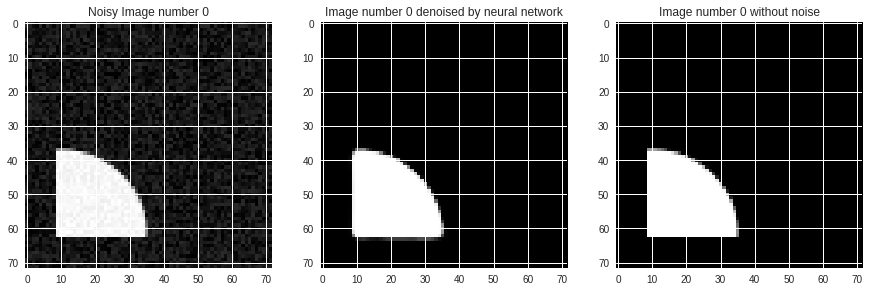

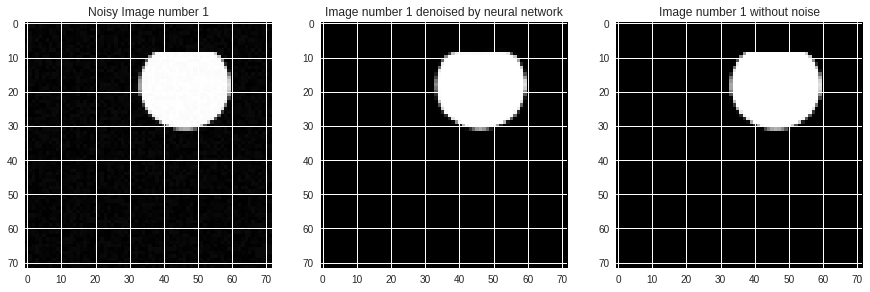

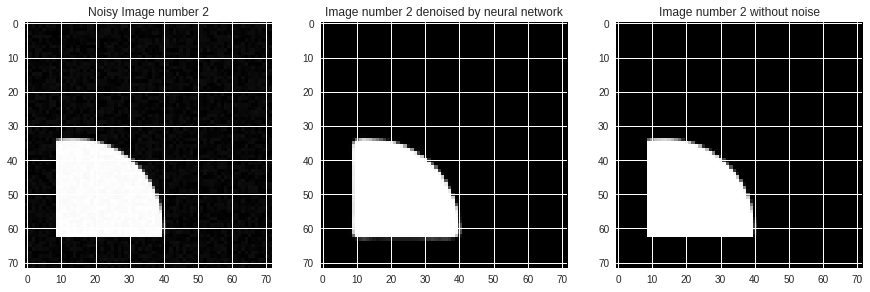

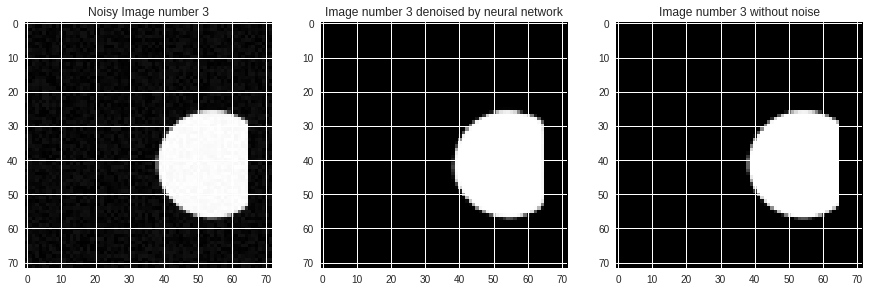

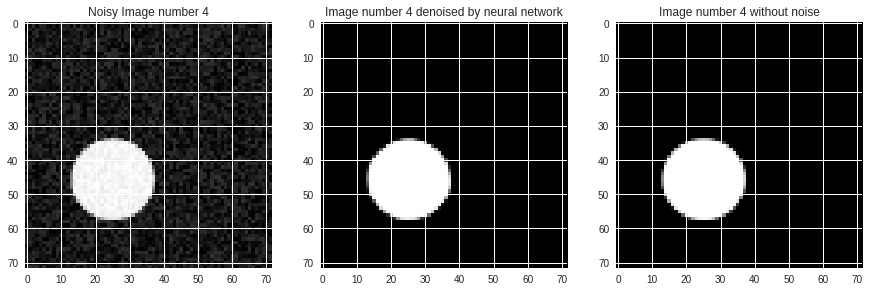

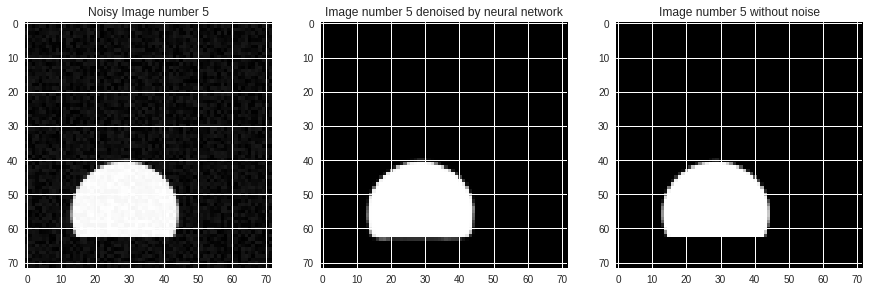

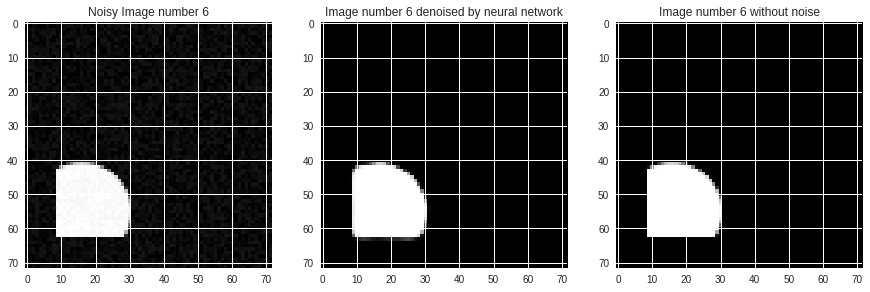

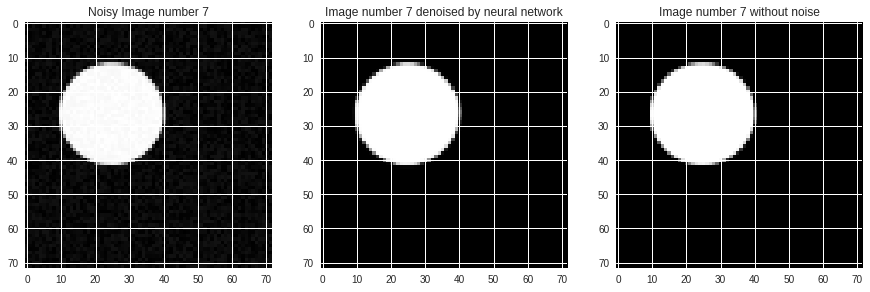

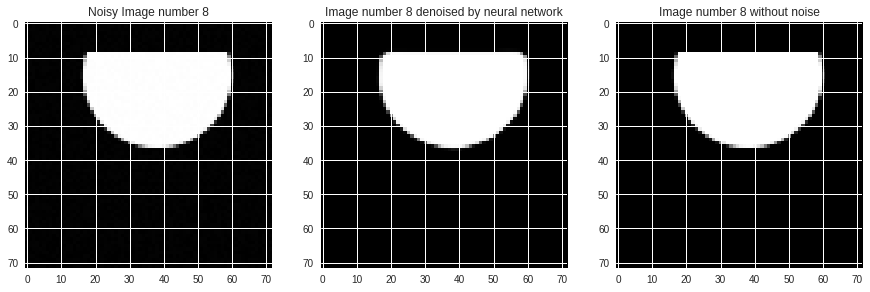

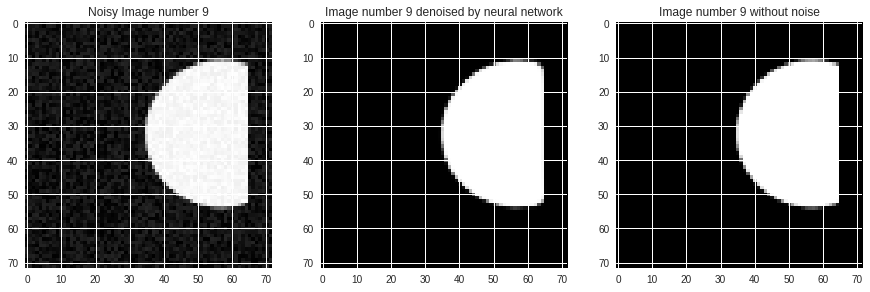

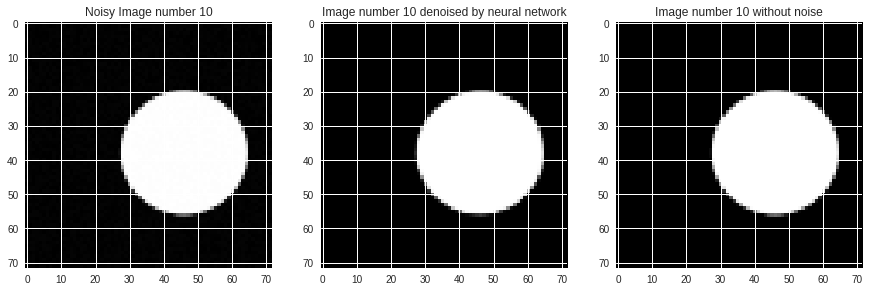

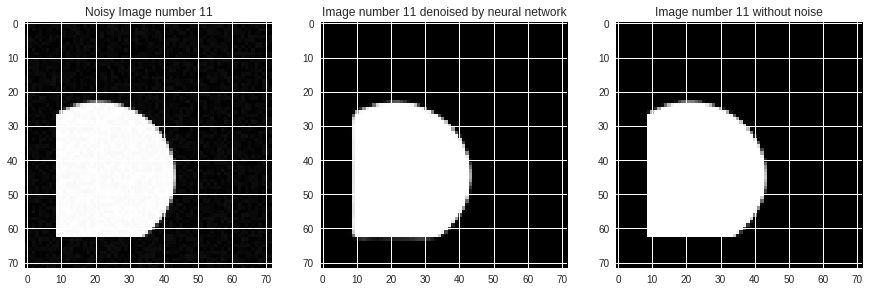

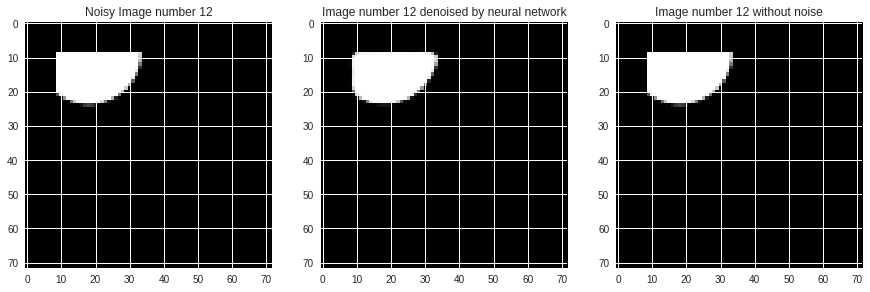

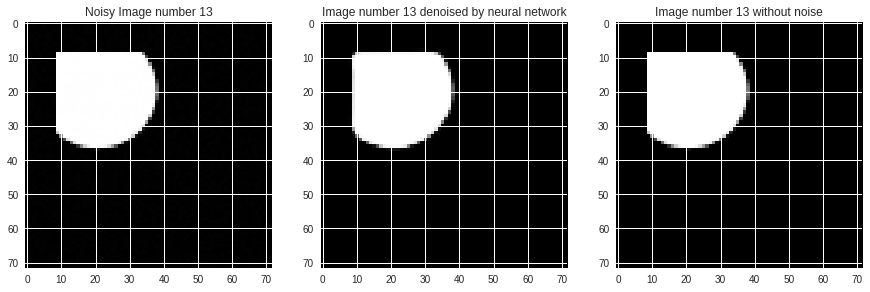

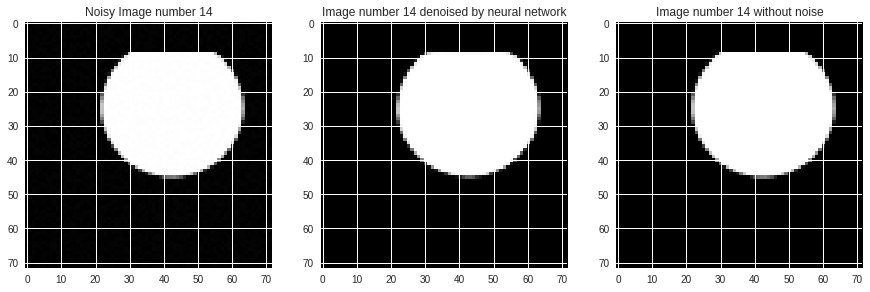

In [66]:
# Generate test set of disks
test_set = np.array([generate_a_disk_noise(True) for k in range(test_size)])
X_test = test_set[:,0]
Y_test = test_set[:,1]
X_test = X_test.reshape(test_size, IMAGE_SIZE, IMAGE_SIZE, 1)
Y_test = Y_test.reshape(test_size, IMAGE_SIZE, IMAGE_SIZE, 1)
X_test /= 255
Y_test /= 255

for j in range(test_size):
    fig = plt.figure(figsize = (15,30))
    fig.tight_layout()
    ax = plt.subplot(1, 3, 1)
    im = X_test[j]
    plt.imshow(im.reshape((IMAGE_SIZE,IMAGE_SIZE)))
    plt.title("Noisy Image number "+str(j))

    ax = plt.subplot(1, 3, 2)
    plt.imshow((denoiser.predict(im.reshape((1,IMAGE_SIZE,IMAGE_SIZE,1)))).reshape((IMAGE_SIZE,IMAGE_SIZE)))
    plt.title("Image number "+str(j) +" denoised by neural network")

    ax = plt.subplot(1, 3, 3)
    plt.imshow(Y_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)))
    plt.title("Image number "+str(j) +" without noise")

### Results
- great performance
- background perfectly denoised and with only some pixels wrongfully colored at the boundaries of the figure
- works on all kind of figures even though trained on only one type of figure